## Connected components

For all interactomes:
* Number of connected components
* Size of the largest connected component
* Relative size of the largest connected component
* Average size of the connected components
* Size of the smallest component
* Number of isolated nodes

For all pathways:
- Sizes of connected components for all pathways

In [2]:
import bisect

import networkx as nx
import pandas as pd
import seaborn as sns

import config
from config import GRAPHS_PATH
from lib.networks import get_interactomes

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()

Working directory: c:\git\pathwayanalysisplatform\proteoformnetworks


In [3]:
interactomes = get_interactomes(GRAPHS_PATH)

In [4]:
import itertools

def getTuples(i):
    sizes = [len(c)/i.number_of_nodes() for c in sorted(nx.connected_components(i), key=len, reverse=True)]
    d = [(i.graph["method"], i.graph["level"], s) for s in sizes]
    return d

tuples = [getTuples(i) for i in interactomes]
data = list(itertools.chain.from_iterable(tuples))
data
df_cc = pd.DataFrame(data, columns=['Method', 'Level', 'Size'])
df_cc

,Method,Level,Size
0,no_sm,genes,0.81
1,no_sm,genes,0.01
2,no_sm,genes,0.00
3,no_sm,genes,0.00
4,no_sm,genes,0.00
...,...,...,...
13277,with_unique_sm,proteoforms,0.00
13278,with_unique_sm,proteoforms,0.00
13279,with_unique_sm,proteoforms,0.00
13280,with_unique_sm,proteoforms,0.00


c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


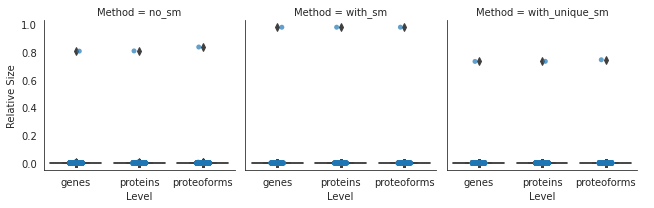

In [5]:
# Requires creating a dataframe with two columns
with sns.axes_style("white"):
    g = sns.FacetGrid(df_cc, col="Method")
g.map(sns.stripplot, "Level", "Size", alpha=.7)
g.map(sns.boxplot, "Level", "Size")
g.set_axis_labels("Level", "Relative Size")
g.add_legend()

In [6]:
# Number of connected components
# Size of the largest connected component
# Relative size of the largest connected component
# Average size of the connected components
# Size of the smallest component
# Number of isolated nodes

def getTuples(i):
    ccs_sizes = [len(c) for c in sorted(nx.connected_components(i), key=len, reverse=False)]
    num_ccs = len(ccs_sizes)

    return (
        i.graph["method"],
        i.graph["level"],
        num_ccs,
        ccs_sizes[-1],
        ccs_sizes[-1]/i.number_of_nodes(),
        sum(ccs_sizes) / len(ccs_sizes),
        ccs_sizes[0],
        bisect.bisect_left(ccs_sizes, 2, lo=0, hi=len(ccs_sizes))
    )

data = [getTuples(i) for i in interactomes]
columns = [
    'Method',
    'Level',
    'Number of connected components',
    'Size of largest connected component',
    'Relative size of largest connected component',
    'Average size of connected components',
    "Size of smallest connected component",
    "Number of isolated nodes"
]
df_interactomes = pd.DataFrame.from_records(data, columns=columns)
df_interactomes

,Method,Level,Number of connected components,Size of largest connected component,Relative size of largest connected component,Average size of connected components,Size of smallest connected component,Number of isolated nodes
0,no_sm,genes,1773,8869,0.81,6.19,1,1664
1,no_sm,proteins,1774,8966,0.81,6.24,1,1665
2,no_sm,proteoforms,1821,11984,0.84,7.85,1,1696
3,with_sm,genes,195,12692,0.98,66.32,1,166
4,with_sm,proteins,195,12790,0.98,66.83,1,166
5,with_sm,proteoforms,205,15962,0.98,79.32,1,173
6,with_unique_sm,genes,2427,28696,0.73,16.10,1,1152
7,with_unique_sm,proteins,2427,28793,0.73,16.14,1,1152
8,with_unique_sm,proteoforms,2465,31644,0.75,17.20,1,1159


In [11]:
from pathlib import Path
from config import METHODS, PATHWAY_GRAPHS_PATH
from config import LEVELS
from lib.networks import get_json_filename, create_pathway_interaction_network, read_graph
from lib.graph_database_access import get_pathways

def get_pathway_tuples(pathway, pathway_graph):
    return (pathway, *getTuples(pathway_graph))

data_pathways = []
for pathway in get_pathways()["stId"][0:5]:
    for method in METHODS:
        for level in LEVELS:
            filename = get_json_filename(level, method, PATHWAY_GRAPHS_PATH, pathway)
            if not Path(filename).exists():
                create_pathway_interaction_network(pathway, level, method, PATHWAY_GRAPHS_PATH)
            G = read_graph(filename)
            data_pathways.append(get_pathway_tuples(pathway, G))

df_pathways = pd.DataFrame.from_records(data_pathways, columns=['Pathway',*columns])
df_pathways

,Pathway,Method,Level,Number of connected components,Size of largest connected component,Relative size of largest connected component,Average size of connected components,Size of smallest connected component,Number of isolated nodes
0,R-HSA-9613829,no_sm,genes,1,21,1.00,21.00,21,0
1,R-HSA-9613829,no_sm,proteins,1,21,1.00,21.00,21,0
2,R-HSA-9613829,no_sm,proteoforms,1,22,1.00,22.00,22,0
3,R-HSA-9613829,with_sm,genes,1,22,1.00,22.00,22,0
4,R-HSA-9613829,with_sm,proteins,1,22,1.00,22.00,22,0
5,R-HSA-9613829,with_sm,proteoforms,1,23,1.00,23.00,23,0
6,R-HSA-9613829,with_unique_sm,genes,1,25,1.00,25.00,25,0
7,R-HSA-9613829,with_unique_sm,proteins,1,25,1.00,25.00,25,0
8,R-HSA-9613829,with_unique_sm,proteoforms,1,26,1.00,26.00,26,0
9,R-HSA-1632852,no_sm,genes,5,102,0.89,22.80,1,2


0    R-HSA-9613829
1    R-HSA-1632852
2    R-HSA-5205685
3    R-HSA-8934903
4    R-HSA-9613354
Name: stId, dtype: object